<a href="https://colab.research.google.com/github/kumaripriyanshukp/image-caption-generator-using-deep-learning/blob/main/image_caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

dataset_path = '/content/drive/My Drive/image-caption/'
print("Files in dataset folder:")
print(os.listdir(dataset_path))

Files in dataset folder:
['captions.txt', 'Images']


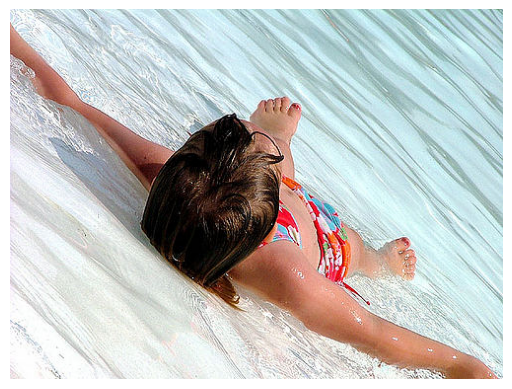

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Path to an example image
img_path = '/content/drive/My Drive/image-caption/Images/667626_18933d713e.jpg'

# Open and display the image
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
# Load captions file
captions_path = '/content/drive/My Drive/image-caption/captions.txt'  # or Flickr8k.token.txt depending on your download
with open('/content/drive/My Drive/image-caption/captions.txt', 'r') as f:
    captions = f.readlines()

# Find and print caption for the image
image_id = img_path.split('/')[-1]
for line in captions:
    if image_id in line:
        print(line.strip())

667626_18933d713e.jpg,A girl is stretched out in shallow water
667626_18933d713e.jpg,A girl wearing a red and multi-colored bikini is laying on her back in shallow water .
667626_18933d713e.jpg,A little girl in a red swimsuit is laying on her back in shallow water .
667626_18933d713e.jpg,"A young girl is lying in the sand , while ocean water is surrounding her ."
667626_18933d713e.jpg,Girl wearing a bikini lying on her back in a shallow pool of clear blue water .


In [ ]:
#import libararies
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
# NLP Imports
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, add,Input,Dense,Dropout, Concatenate, Reshape, concatenate, Bidirectional
# Model Creation Imports
from tensorflow.keras.models import Sequential, Model, load_model
# Computer Vision Imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
# Model Learning and Losses Imports
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# Warning & Visualization Imports
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [ ]:
#Load dataset
image_path = '/content/drive/My Drive/image-caption/Images'
data = pd.read_csv("/content/drive/My Drive/image-caption/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


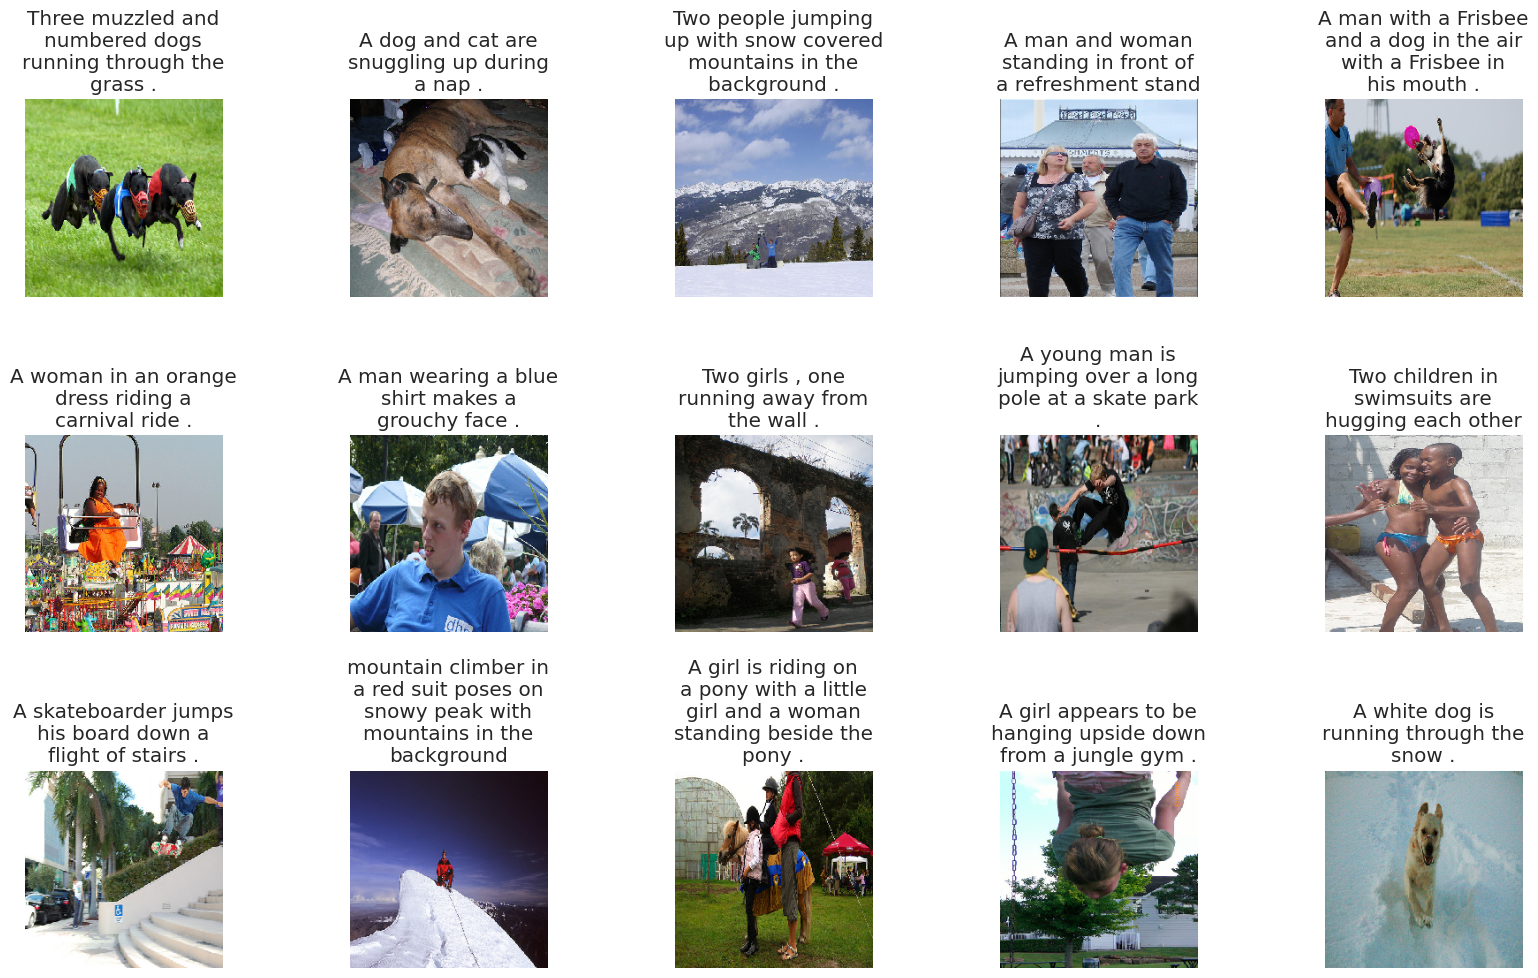

In [ ]:
def readImage(path, img_size = 224):
    img = load_img(path, color_mode = 'rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img/255. # 0,1
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20,20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5,5,n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/drive/My Drive/image-caption/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i],20)))
        plt.axis("off")

display_images(data.sample(15))



In [ ]:
import pandas as pd

def text_preprocessing(data):
    # Convert all values to strings and handle NaN values
    data['caption'] = data['caption'].astype(str).fillna('')

    # Convert to lowercase
    data['caption'] = data['caption'].apply(lambda x: x.lower() if isinstance(x, str) else '')

    # Remove non-alphabetic characters using regex
    data['caption'] = data['caption'].str.replace(r"[^A-Za-z\s]", "", regex=True)

    # Remove extra spaces
    data['caption'] = data['caption'].str.replace(r"\s+", " ", regex=True).str.strip()

    # Remove single-character words
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))

    # Add "startseq" and "endseq"
    data['caption'] = data['caption'].apply(lambda x: f"startseq {x} endseq")

    return data

# Assuming 'data' is your DataFrame
data = text_preprocessing(data)

captions = data['caption'].tolist()  # Convert processed column to a list
captions[:10] # Print first 10 captions

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(captions)

vocab_size = len(tokenizer.word_index) + 1

max_length = max([len(caption.split())for caption in captions])

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])


[[1, 18, 312, 63, 192, 116, 2]]

In [ ]:

model = DenseNet201()
fe = Model(inputs = model.input, outputs = model.layers[-2].output)

img_size = 224
features = {}

for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image), target_size = (img_size, img_size))
    img = img_to_array(img)
    img = img/225.
    img = np.expand_dims(img, axis=0)
    feature = fe.predict(img, verbose=0)

    features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


  1%|          | 67/8091 [01:41<2:01:01,  1.11it/s]

In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1,X2), y

    def __get_data(self, batch):
        X1, X2, y = list(), list(), list()
        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1,X2,y = np.array(X1), np.array(X2), np.array(y)
        return X1, X2, y



train_generator = CustomDataGenerator(df = train, X_col = 'image', y_col = 'caption', batch_size = 64, directory = image_path,
                                     tokenizer = tokenizer, vocab_size = vocab_size, max_length = max_length, features = features)
validation_generator = CustomDataGenerator(df = test, X_col = 'image', y_col = 'caption', batch_size = 64, directory = image_path,
                                     tokenizer = tokenizer, vocab_size = vocab_size, max_length = max_length, features = features)

In [ ]:
train_generator[0]

((array([[8.0225363e-05, 7.1590999e-04, 1.1328822e-03, ..., 5.9671587e-01,
          2.3961598e-01, 7.4495953e-01],
         [8.0225363e-05, 7.1590999e-04, 1.1328822e-03, ..., 5.9671587e-01,
          2.3961598e-01, 7.4495953e-01],
         [8.0225363e-05, 7.1590999e-04, 1.1328822e-03, ..., 5.9671587e-01,
          2.3961598e-01, 7.4495953e-01],
         ...,
         [1.9257008e-04, 6.9427019e-04, 1.4791867e-03, ..., 1.8175701e-02,
          4.8175126e-01, 4.1156593e-01],
         [1.9257008e-04, 6.9427019e-04, 1.4791867e-03, ..., 1.8175701e-02,
          4.8175126e-01, 4.1156593e-01],
         [1.9257008e-04, 6.9427019e-04, 1.4791867e-03, ..., 1.8175701e-02,
          4.8175126e-01, 4.1156593e-01]], dtype=float32),
  array([[  0,   0,   0, ...,   0,   0,   1],
         [  0,   0,   0, ...,   0,   1,  41],
         [  0,   0,   0, ...,   1,  41,   3],
         ...,
         [  0,   0,   0, ...,  10,  76,  49],
         [  0,   0,   0, ...,  76,  49,   4],
         [  0,   0,   0, ...,

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import nltk
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
from tensorflow.keras.callbacks import Callback

# Inputs
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

# Image feature processing
img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1,256), input_shape=(256,))(img_features)

# Text feature processing
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

# Merge image and text features
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)

x = Dropout(0.5)(sentence_features)
x = add([x, sentence_features])

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)


# Final dense layer for word prediction
output = Dense(vocab_size, activation='softmax')(x)  # Only use the last time step

# Build the model
caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

# Callbacks
model_name = "model.keras"
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    #mon = "val_profit",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

#class BLEUScore(Callback):
    #def __init__(self, val_generator, n=4):
      #  super().__init__()
      #  self.val_generator = val_generator
      #  self.n = n
       # self.scores = []

    #def on_epoch_end(self, epoch, logs=None):


                # Calculate BLEU
               # score = sentence_bleu([reference_seq], predicted_seq, weights=[1/self.n]*self.n)
               # total_bleu += score
                #count += 1

            # Stop after one complete pass
            #break

        # Calculate average BLEU for this epoch
        #avg_bleu = total_bleu / count
       # self.scores.append(avg_bleu)
        #print(f"Epoch {epoch+1} - BLEU-{self.n} Score: {avg_bleu:.4f}")

        # Add to logs for visualization
        #logs['bleu_score'] = avg_bleu

earlystopping = EarlyStopping(monitor='val_loss', patience=5,verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=0.00000001)
#bleu_metric = BLEUScore(val_generator=validation_generator)

# Train the model
history = caption_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]
)

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 5.8286
Epoch 1: val_loss improved from inf to 4.45453, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 101s 180ms/step - loss: 5.8274 - val_loss: 4.4545 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 4.5107
Epoch 2: val_loss improved from 4.45453 to 4.19261, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 94s 176ms/step - loss: 4.5106 - val_loss: 4.1926 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 4.2592
Epoch 3: val_loss improved from 4.19261 to 4.02980, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 98s 182ms/step - loss: 4.2591 - val_loss: 4.0298 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 4.0755
Epoch 4: val_loss improved from 4.02980 to 3.94206, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 101s 189ms/step - loss: 4.0755 - val_loss: 3.9421 - learning_rate: 0.001

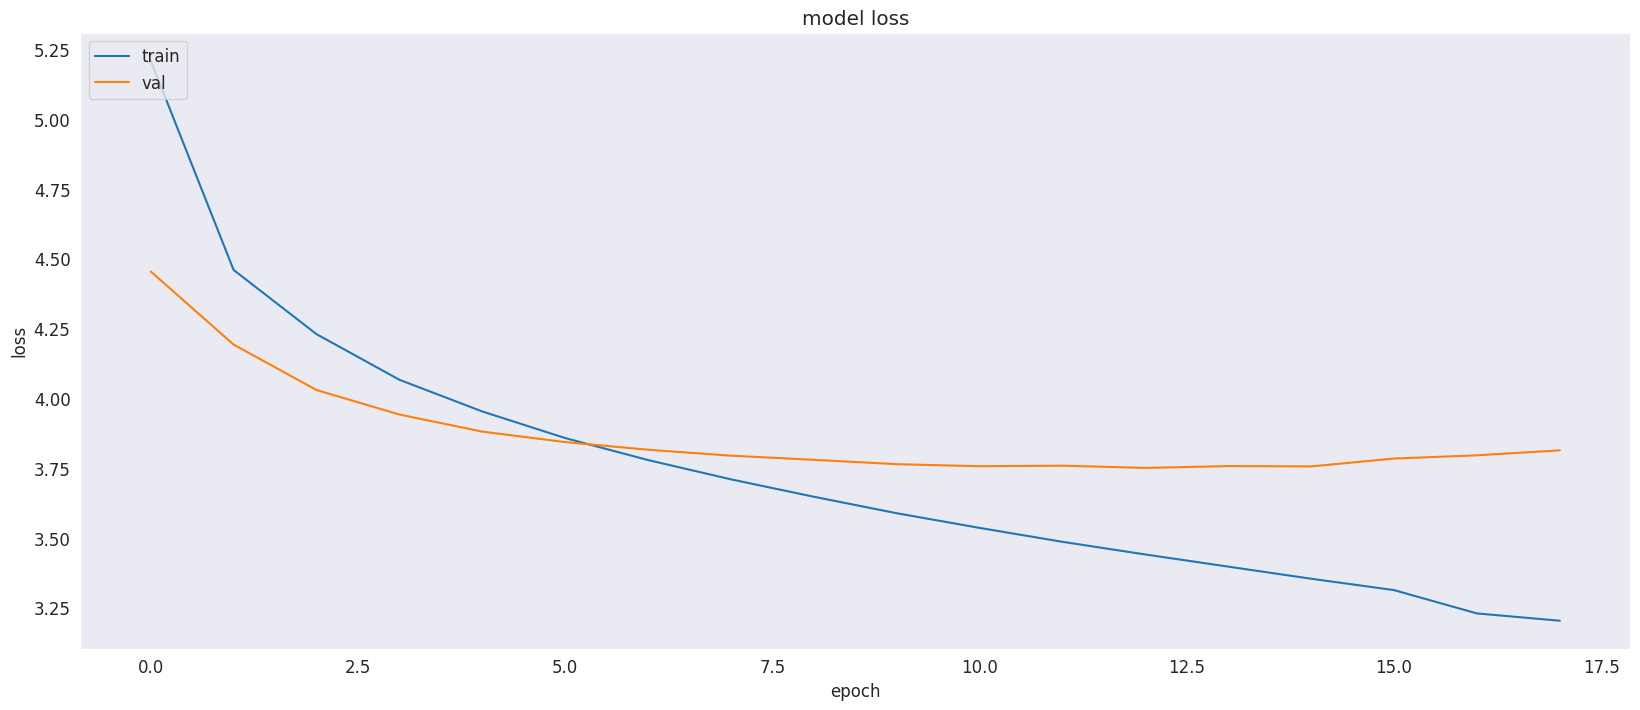

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
import pickle
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))
pickle.dump(fe, open('feature_extractor.pkl', 'wb'))

In [ ]:
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
fe.save('feature_extractor.keras')

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

#load save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"

def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34,img_size=224):
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)
    tokenizer = pickle.load(open("tokenizer.pkl", "rb"))

    # preprocess and read image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    image_features = feature_extractor.predict(img, verbose=0)

    # generate caption for new image
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index,None)
        if word is None:
            break
        in_text += " "+ word
        if word == 'endseq':
            break
    caption = in_text.replace('startseq', '').replace('endseq', '').strip()

    # Display the image
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

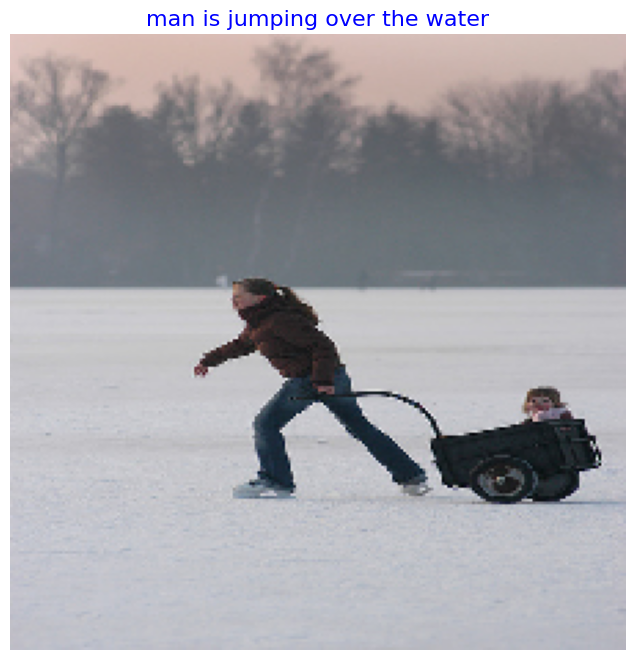

In [ ]:
#example usage
image_path = "/content/drive/My Drive/image-caption/Images/94232465_a135df2711.jpg" #Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

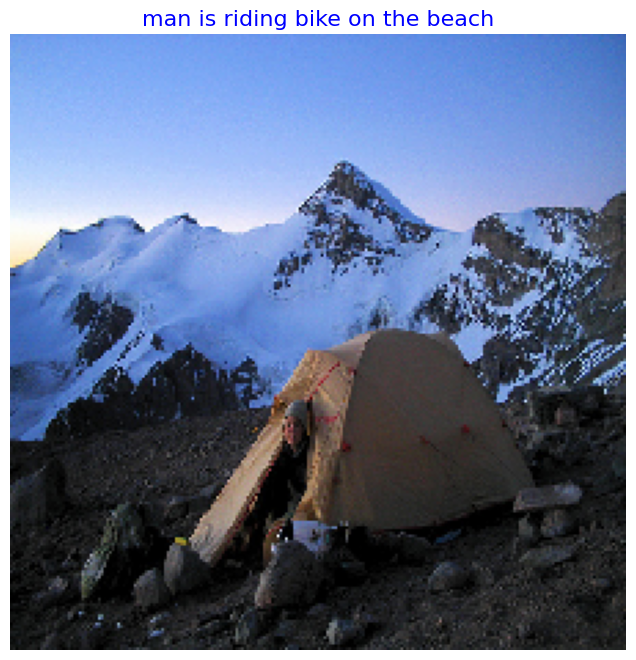

In [ ]:
image_path = "/content/drive/My Drive/image-caption/Images/57422853_b5f6366081.jpg" #Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)